In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.signal import savgol_filter, find_peaks
from sympy import symbols, Eq, solve
import os

In [2]:
def FindReference(img):

    # Convert image to LAB color space
    LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Define lower and upper bounds for blue color in LAB color space
    lower_blue = np.array([100, 100, 0], dtype=np.uint8)
    upper_blue = np.array([255, 150, 100], dtype=np.uint8)

    # Create mask based on blue color range
    mask = cv2.inRange(LAB, lower_blue, upper_blue)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    contour_img = img.copy()

    # Find the contour with the largest area
    main_contour = max(contours, key=cv2.contourArea)

    # Create a mask for segmented pixels using the main contour
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [main_contour], -1, (255, 255, 255), cv2.FILLED)

    # Apply the mask to the original image
    segmented_img = cv2.bitwise_and(img, mask)

    # Create a mask for contour outlines using the main contour
    contour_outline_mask = np.zeros_like(img)
    cv2.drawContours(contour_outline_mask, [main_contour], -1, (0, 255, 0), thickness=8)

    # Combine contour outlines with original image
    image_with_contour = cv2.addWeighted(img, 1, contour_outline_mask, 1, 0)

    #----------------------------------------------------------------------------------------

    # Compute minimum area bounding rectangle
    sqr = cv2.minAreaRect(main_contour)

    # Get the vertices of the rectangle
    box = cv2.boxPoints(sqr)
    box = np.intp(box)

    ref_contour = np.array([box], dtype=np.int32)
    cv2.polylines(image_with_contour, ref_contour, isClosed=True, color=(0, 0, 255), thickness=9)

    width = np.linalg.norm(box[0] - box[1])

    # Calculate the conversion rate assuming the width of the segmented shape is 2cm
    Distance_in_cm = 2
    conversion_rate = Distance_in_cm/width

    # print ("Conversion: 1 pixel = ", conversion_rate)

    ## Calculate the mask for the ref_contour region
    ref_contour_mask = np.zeros_like(img)
    cv2.drawContours(ref_contour_mask, [ref_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Apply the mask to the original image to remove the ref_contour region
    img = cv2.bitwise_and(img, cv2.bitwise_not(ref_contour_mask))

    #----------------------------------------------------------------------------------------

    # Plot the images
    plt.figure(figsize=(12, 6))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_contour, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Plot the cropped image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Image (Ref Contour Removed)')
    plt.axis('off')

    plt.show()

    #----------------------------------------------------------------------------------------

    return [img, conversion_rate]

def SegmentImage(img):

    # Convert image to LAB color space
    LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Extract hue and saturation channels
    L, a, b = cv2.split(LAB)

    # Threshold the hue channel to identify the region of interest
    _, thresholded = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    contour_img = img.copy()

    # Find the contour with the largest area
    main_contour = max(contours, key=cv2.contourArea)

    # Create a mask for segmented pixels using the main contour
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [main_contour], -1, (255, 255, 255), cv2.FILLED)

    # Apply the mask to the original image
    segmented_img = cv2.bitwise_and(img, mask)

    # Create a mask for contour outlines using the main contour
    contour_outline_mask = np.zeros_like(img)
    cv2.drawContours(contour_outline_mask, [main_contour], -1, (0, 255, 0), thickness=2)

    # Combine contour outlines with original image
    image_with_contour = cv2.addWeighted(img, 1, contour_outline_mask, 1, 0)

    # Convert BGR to RGB for matplotlib
    segmented_img_rgb = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)
    image_with_contour_rgb = cv2.cvtColor(image_with_contour, cv2.COLOR_BGR2RGB)

    # Threshold the grayscale image to obtain only the segmented pixels
    segmented_gray = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)
    _, segmented_pixels = cv2.threshold(segmented_gray, 1, 255, cv2.THRESH_BINARY)

    # Plot the images
    plt.figure(figsize=(18, 6))

    # Plot the original image with contour outlines
    plt.subplot(1, 3, 1)
    plt.imshow(image_with_contour_rgb)
    plt.title('Original Image with Contour Outline')
    plt.axis('off')

    # Plot the original image with only segmented pixels
    plt.subplot(1, 3, 2)
    plt.imshow(segmented_pixels, cmap='gray')
    plt.title('Original Image with Segmented Pixels')
    plt.axis('off')

    # Plot the segmented image
    plt.subplot(1, 3, 3)
    plt.imshow(segmented_img_rgb)
    plt.title('Segmented Image')
    plt.axis('off')

    plt.show()

    return main_contour

    # print (main_contour)

def CalcSize_Tomato(img, main_contour, pixel_conversion):
    x, y, w, h = cv2.boundingRect(main_contour)

    # Calculate major and minor axes
    length = max(w, h)
    width = min(w, h)

    # Calculate average diameter
    avg_diameter_pixels = (length + width) / 2

    # Draw the bounding box on the original image
    image_with_bounding_box = img.copy()
    cv2.rectangle(image_with_bounding_box, (x, y), (x + w, y + h), (0, 2555, 0), 8)

    # Convert BGR to RGB for matplotlib
    image_with_bounding_box_rgb = cv2.cvtColor(image_with_bounding_box, cv2.COLOR_BGR2RGB)

    # Plot the original image with the bounding box
    # plt.figure(figsize=(6, 6))
    # plt.imshow(image_with_bounding_box_rgb)
    # plt.title('Original Image with Bounding Box')
    # plt.axis('off')
    # plt.show()

    #-----------------------------------------------------
    diameter_cm = avg_diameter_pixels * pixel_conversion
    #-----------------------------------------------------
    return diameter_cm

    # print("Pixel Lenght:",avg_diameter)

def CalcSize_Carrot(main_contour, pixel_conversion, view):
    
    x, y, w, h = cv2.boundingRect(main_contour)

    if view=='top':
        # Calculate major and minor axes
        length = max(w, h)
        width = min(w, h)

        # Calculate average diameter
        avg_diameter_pixels = (length + width) / 2

        #-----------------------------------------------------
        diameter_cm = avg_diameter_pixels * pixel_conversion
        #-----------------------------------------------------
        return diameter_cm
    
    else:
        length = max(w, h)
        width = min(w, h)

        #-----------------------------------------------------
        length_cm = length * pixel_conversion
        #-----------------------------------------------------
        return length_cm

def FindShape_Top(img, main_contour):
    # # Calculate the center and radius of the ideal circle

    # Assuming you already have the bounding box coordinates
    x, y, w, h = cv2.boundingRect(main_contour)

    center = (x + w // 2, y + h // 2)
    radii = [w//2, h//2]

    # Calculate area and perimeter of the contour
    contour_area = cv2.contourArea(main_contour)
    contour_perimeter = cv2.arcLength(main_contour, True)

    # Calculate the minimum enclosing circle
    (xc_min, yc_min), enclosed_rad = cv2.minEnclosingCircle(main_contour)
    enclosed_rad = int(enclosed_rad)
    # radius_min = max(radii)

    contour_np = main_contour.squeeze()

    # Initialize maximum inscribed circle radius
    inscribe_rad = enclosed_rad

    # Iterate over each point in the contour
    for point in contour_np:
        # Calculate distance between the point and the center of the minimum enclosing circle
        distance = np.sqrt((point[0] - xc_min)**2 + (point[1] - yc_min)**2)
        
        # Update maximum inscribed circle radius if current distance is smaller
        inscribe_rad = min(inscribe_rad, distance)
    inscribe_rad = int(inscribe_rad)

    # Calculate circularity indicators
    E1 = (4 * math.pi * contour_area) / (contour_perimeter ** 2)
    E2 = contour_area / (math.pi * enclosed_rad ** 2)
    E3 = (math.pi * inscribe_rad ** 2) / (math.pi * enclosed_rad ** 2)

    # print("Circularity Indicator E1:", E1)
    print("Circularity Indicator E2:", E2)
    print("Circularity Indicator E3:", E3)

    contour_canvas = img.copy()

    # Draw the original contour
    cv2.drawContours(contour_canvas, [main_contour], -1, (0, 255, 0), 8)

    # Draw the minimum enclosing circle
    cv2.circle(contour_canvas, (int(xc_min), int(yc_min)), enclosed_rad, (0, 0, 255), 8)

    # Draw the maximum inscribed circle
    cv2.circle(contour_canvas, center, inscribe_rad, (255, 0, 0), 8)

    # Convert BGR to RGB for plotting with matplotlib
    contour_canvas = cv2.cvtColor(contour_canvas, cv2.COLOR_BGR2RGB)

    # Plot the image with contours
    # plt.imshow(image_rgb)
    plt.imshow(contour_canvas)
    plt.title('Image with Contours')
    plt.axis('off')

    legend_elements = [
        plt.Line2D([0], [0], color='g', lw=2, label='Original Contour'),
        plt.Line2D([0], [0], color='r', lw=2, label='Minimum Enclosing Circle'),
        plt.Line2D([0], [0], color='b', lw=2, label='Maximum Inscribed Circle')
    ]
    plt.legend(handles=legend_elements)

    plt.show()

    return [['E2', E2], ['E3', E3]]

def FindShpae_Side_Tomato(main_contour):
    # Calculate the minimum circumscribed rectangle around the tomato contour
    rect = cv2.minAreaRect(main_contour)
    box = np.intp(cv2.boxPoints(rect))

    # Extract width and height from the rectangle
    W = rect[1][0]
    H = rect[1][1]

    # Calculate the area of the projected side profile of the tomato contour
    # You may need to project the contour onto a plane parallel to the image plane
    AC = cv2.contourArea(main_contour)

    # Calculate the minimum enclosing circle of the tomato contour
    (xc_min, yc_min), radius_min = cv2.minEnclosingCircle(main_contour)

    # Plot the tomato contour, minimum circumscribed rectangle, and minimum enclosing circle
    plt.figure(figsize=(8, 6))

    # Plot tomato contour
    plt.plot(main_contour[:, 0, 0], main_contour[:, 0, 1], '-g', label='Tomato Contour')

    # Plot minimum circumscribed rectangle
    plt.plot(box[:, 0], box[:, 1], '-b', label='Minimum Circumscribed Rectangle')

    # Plot minimum enclosing circle
    circle = plt.Circle((xc_min, yc_min), radius_min, color='r', fill=False, label='Minimum Enclosing Circle')
    plt.gca().add_patch(circle)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Tomato Contour with Minimum Circumscribed Rectangle and Minimum Enclosing Circle')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.grid(True)
    plt.show()

    # print("Longitudinal Diameter (H):", H)
    # print("Transverse Diameter (W):", W)
    # print("Projected Area of Side Profile (AC):", AC)
    # print("Minimum Circumscribed Circle Radius (Rmin):", radius_min)

    # Calculate ratios
    SC = min(H, W) / max(H, W)
    EC = AC / (math.pi * radius_min**2)

    print("Ratio of Longitudinal Diameter to Transverse Diameter (SC):", SC)
    print("Circularity Index of Side Profile (EC):", EC)

    #-----------------------------------------------------------------------------
    #                                      SYMMETRY
    #-----------------------------------------------------------------------------

    # # Calculate the centroid of the tomato contour
    # M = cv2.moments(main_contour)
    # centroid_x = int(M['m10'] / M['m00'])
    # centroid_y = int(M['m01'] / M['m00'])
    # centroid = (centroid_x, centroid_y)

    # # Calculate distances from centroid to all contour points
    # distances = np.sqrt(np.sum((main_contour - centroid)**2, axis=2))
    # distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    # # Find local maxima and minima of centroid distances
    # local_maxima_indices = argrelextrema(distances, np.greater)[0]
    # local_minima_indices = argrelextrema(distances, np.less)[0]

    # # Filter local minima within the specified range
    # contour_length = len(main_contour)
    # pedicle_candidates = [idx for idx in local_minima_indices if (idx >= contour_length/5) and (idx <= 4*contour_length/5)]

    # # Select the minimum point within the range as the pedicle point
    # pedicle_index = min(pedicle_candidates, key=lambda idx: distances[idx])

    # # Smooth the curve using Savitzky-Golay filter
    # smoothed_distances = savgol_filter(distances.flatten(), window_length=11, polyorder=2)

    # # Pedicle coordinates
    # pedicle_point = (pedicle_index, smoothed_distances[pedicle_index])

    # # Find peaks and valleys on the smoothed curve
    # peaks, _ = find_peaks(smoothed_distances, prominence=0.01)  # Adjust prominence threshold here
    # valleys, _ = find_peaks(-smoothed_distances, prominence=0.01)  # Adjust prominence threshold here

    # # Plot centroid distance vs contour point with peaks, valleys, and pedicle point
    # plt.plot(smoothed_distances, label='Smoothed Curve')
    # plt.plot(peaks, smoothed_distances[peaks], "x", label="Peaks")
    # plt.plot(valleys, smoothed_distances[valleys], "o", label="Valleys")
    # plt.plot(pedicle_point[0], pedicle_point[1], 'ro', label='Pedicle Point')
    # plt.xlabel('Contour Point Index')
    # plt.ylabel('Centroid Distance')
    # plt.title('Centroid Distance vs Contour Point Index')
    # plt.legend()
    # plt.show()

    # # Assuming you already have the pedicle point 'pedicle_index' and all the peaks 'peaks'
    # # peaks_y =  smoothed_distances[peaks]

    # # Find the peaks closest to the left and right of the pedicle point
    # if len(peaks) <=1:
    #     difference = 0
    # else:
    #     closest_left_peak = max(filter(lambda peak: peak < pedicle_point[0], peaks), default=None)
    #     closest_right_peak = min(filter(lambda peak: peak > pedicle_point[0], peaks), default=None)

    #     closest_left_peak_cdist = smoothed_distances[closest_left_peak] if closest_left_peak is not None else None
    #     closest_right_peak_cdist = smoothed_distances[closest_right_peak] if closest_right_peak is not None else None

    #     if closest_left_peak_cdist is not None and closest_right_peak_cdist is not None:
    #         difference = abs(closest_right_peak_cdist - closest_left_peak_cdist)
    #     else:
    #         difference = 0

    # symmetry_sc = difference

    # # print(peaks)
    # # print (closest_left_peak, closest_right_peak)
    # # print(pedicle_point)
    # # print("Numerical Difference between the two adjacent peaks:", symmetry_sc)

    # return [['SC', SC], ['EC', EC], ['Sym', symmetry_sc] ]
    return [['SC', SC], ['EC', EC]]

def FindShape_Side_Carrot(img ,main_contour, width):
    ideal_dia_base = width

    # Create a black image to draw the contour and ideal shape
    image = img.copy()
    img_length = img.shape[1] 

    # Draw the contour of the segmented carrot on the image
    # cv2.drawContours(image, [main_contour], -1, (255, 255, 255), 9)

    # Assuming 'main_contour' contains the contour
    max_x_point = None
    max_x = -float('inf')  # Initialize max_x to negative infinity

    for point in main_contour:
        x = point[0][0]  # x-coordinate of the point
        if x > max_x:
            max_x = x
            max_x_point = point

    cPoint_x, cPoint_y = max_x_point[0]
    # print(x, y)
    plt.scatter(cPoint_x,cPoint_y, color="white")

    #----------------------------------------------------------------------------------

    # Compute minimum area bounding rectangle
    rect = cv2.minAreaRect(main_contour)

    # Get the vertices of the rectangle
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Flatten the array of points to simplify comparison
    flattened_points = [point for point in box]

    # Sort the flattened points based on their x-coordinate first, then their y-coordinate
    sorted_points = sorted(flattened_points, key=lambda p: (p[0], p[1]))

    # Determine which point is the top left, bottom left, top right, and bottom right
    tl_box, bl_box, tr_box, br_box = sorted_points[0], sorted_points[1], sorted_points[2], sorted_points[3]

    # print("Top Left (Bounding Box):", tl_box)
    # print("Bottom Left (Bounding Box):", bl_box)
    # print("Top Right (Bounding Box):", tr_box)
    # print("Bottom Right (Bounding Box):", br_box)


    length = np.linalg.norm(tl_box - tr_box)
    width = np.linalg.norm(tl_box - bl_box)
    print(width)
    # ideal_dia_base = width

    # Ensure width is the shorter distance and length is the longer
    if width > length:
        width, length = length, width


    # Convert the vertices into a contour format
    bounding_contour = np.array([box], dtype=np.int32)
    # area_box = cv2.polylines(image, bounding_contour, isClosed=True, color=(255, 100, 0), thickness=4)

    #----------------------------------------------------------------------------------

    # Find the lengths of the sides
    sl = [np.linalg.norm(box[i] - box[(i + 1) % 4]) for i in range(4)]
    sp = [[box[i], box[(i + 1) % 4]] for i in range(4)]
    # print(sp)

    # Find the indices of the shorter sides
    ssi = sorted(range(len(sl)), key=lambda i: sl[i])[:2]
    # print(ssi)

    # Retrieve the points representing the ends of the shorter sides
    ssp = [sp[i] for i in ssi]
    # print(ssp)

    # Flatten the array of points to simplify comparison
    flattened_points = [point for pair in ssp for point in pair]

    # Sort the flattened points based on their x-coordinate first, then their y-coordinate
    sorted_points = sorted(flattened_points, key=lambda p: (p[0], p[1]))

    # Determine which point is the top left, bottom left, top right, and bottom right
    tl, bl, tr, br = sorted_points[0], sorted_points[1], sorted_points[2], sorted_points[3]

    # Determine the length of the right side of the tapered cylinder (35% of the length)
    # print(ideal_dia_base, width)
    taper = 0.45

    lFactor = ideal_dia_base/width
    lFactor = (1-lFactor)/2
    # print(lFactor)

    rFactor = (ideal_dia_base * taper)/width
    rFactor = (1-rFactor)/2
    # print(rFactor)

    # tapered_length = 0.325 * width
    # print (tapered_length)

    # Interpolate the points to create the tapered cylinder contour
    tapered_box = np.array([
        tl+ (bl - tl) * lFactor,
        tr + (br - tr) * rFactor,  # right-top corner
        br + (tr - br) * rFactor,  # right-bottom corner
        bl+ (tl - bl) * lFactor,  # bottom-left corner
    ])

    midpt_x = (bl[0] + tl[0]) / 2
    midpt_y = (bl[1] + tl[1]) / 2
    # plt.scatter(midpt_x, midpt_y , color='red')

    # Convert the vertices into a contour format
    tapered_contour = np.array([tapered_box], dtype=np.int32)
    # cv2.polylines(image, tapered_contour, isClosed=True, color=(0, 255, 0), thickness=2)

    #----------------------------------------------------------------------------------

    angle = rect[-1]

    # If angle is negative, make it positive
    if angle < -45:
        angle += 90
    elif angle > 45:
        angle -= 90

    # print(angle)

    # Compute centroid of the bounding contour
    M = cv2.moments(main_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    plt.axhline(y=cY, color='r', linestyle='--')

    #----------------------------------------------------------------------------------

    slope = np.tan(np.radians(angle))

    # # Calculate the y-intercept of the line
    # intercept = cY - slope * cX

    # line_length = img_length / math.cos(angle)

    # # Generate x coordinates for the line
    # x_coords = np.array([cX - line_length/2, cX + line_length/2])  # Adjust length as needed
    # # Calculate y coordinates using the equation of the line
    # y_coords = slope * x_coords + intercept
    # # plt.plot(x_coords, y_coords, 'r--')
    
    # Define variables
    x, y = symbols('x y')

    # Equation of the line defined by box[0] and box[3]
    line1_eq = Eq((bl[1] - tl[1]) * (x - tl[0]) - (bl[0] - tl[0]) * (y - tl[1]), 0)

    # Equation of the line you plotted
    line2_eq = Eq(y, cY)

    # Solve the equations to find the intersection point
    intersection_point = solve((line1_eq, line2_eq), (x, y))
    # print(intersection_point)

    # Extract the coordinates of the intersection point
    intersection_x = intersection_point[x]
    intersection_y = intersection_point[y]

    plt.scatter(intersection_x, intersection_y, color="white")

    # Calculate translation offsets
    offset_x = intersection_x - midpt_x
    offset_y = intersection_y - midpt_y

    # plt.scatter(midpt_x, midpt_y , color='green')

    # Define the translation matrix
    M = np.float32([[1, 0, offset_x], [0, 1, offset_y]])

    # Apply the affine transformation to the contour
    translated_contour = cv2.transform(tapered_contour, M)
    # print(translated_contour)

    # cv2.polylines(image, translated_contour, isClosed=True, color=(0, 255, 0), thickness=8)

    #----------------------------------------------------------------------------------

    # Get the coordinates of the second and third points (right-top and right-bottom)
    right_top = translated_contour[0][1]
    right_bottom = translated_contour[0][2]

    # Calculate the midpoint of the right side
    midpoint_right_x = (right_top[0] + right_bottom[0]) / 2
    midpoint_right_y = (right_top[1] + right_bottom[1]) / 2

    # plt.scatter(midpoint_right_x, midpoint_right_y , color='green')

    # Define the coordinates of the midpoint of the right side of the translated contour
    midpoint_right = np.array([midpoint_right_x, midpoint_right_y])

    intersection_x = float(intersection_x)
    intersection_y = float(intersection_y)
    center = (intersection_x, intersection_y)

    plt.plot([center[0], cPoint_x], [center[1],cPoint_y], 'w--')

    # Coordinates of the two points
    x1, y1 = center
    x2, y2 = cPoint_x, cPoint_y

    # Calculate the slope
    slope2 = (y2 - y1) / (x2 - x1)
    n_angle = np.degrees(np.arctan(np.abs((slope2 - slope) / (1 + slope * slope2))))
    if slope2 > slope:
        n_angle = -(n_angle)
    else:
        n_angle = n_angle

    # Generate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, n_angle, scale=1)

    # Apply the rotation to the translated contour
    rotated_contour = cv2.transform(translated_contour, rotation_matrix)

    cv2.polylines(image, rotated_contour, isClosed=True, color=(0, 255, 0), thickness=6)
    #-------------------------------------------------------

    # Create a binary mask for the contour
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [main_contour], -1, 1, thickness=cv2.FILLED)

    # Create a binary mask for the rotated contour
    ideal_mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(ideal_mask, [rotated_contour], -1, 1, thickness=cv2.FILLED)

    # Calculate intersection and union
    intersection = np.logical_and(mask, ideal_mask)
    union = np.logical_or(mask, ideal_mask)
    iou_score = np.sum(intersection) / np.sum(union)


    print("\n\nIoU Score:", iou_score)

    #----------------------------------------------------------------------------------

    match_value = cv2.matchShapes(main_contour, translated_contour, cv2.CONTOURS_MATCH_I3, 0.0)
        
    # Convert match value to percentage (smaller value means more similar)
    # similarity_percentage = (1 - match_value) * 100
    print("Similarity Score:", match_value)

    #----------------------------------------------------------------------------------

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.axis('off')

    plt.show()

    return [['IoU', iou_score], ['Sim_score', match_value]]

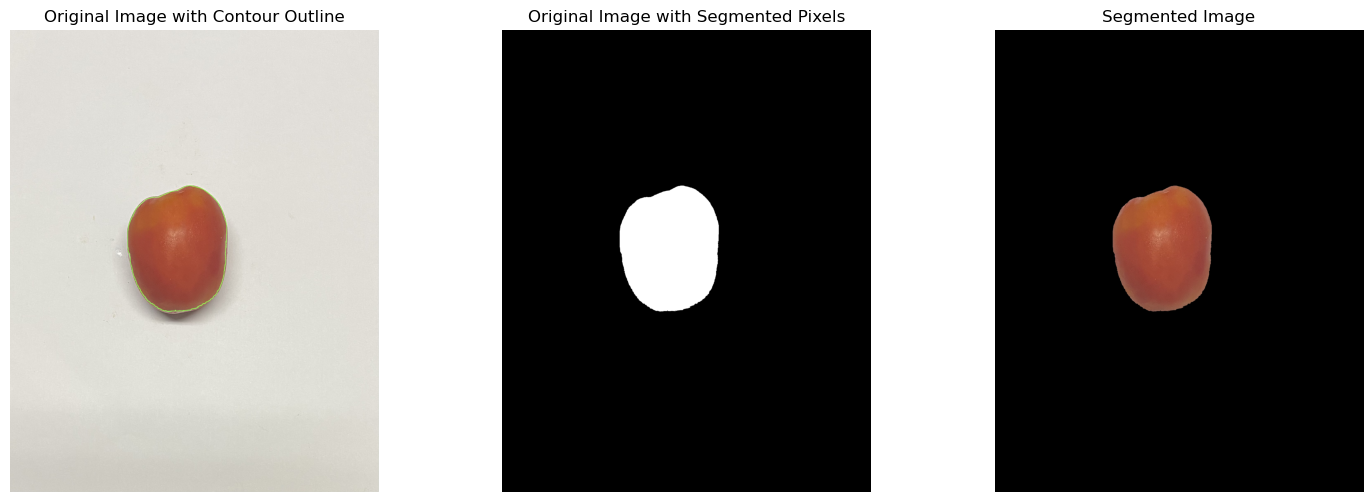

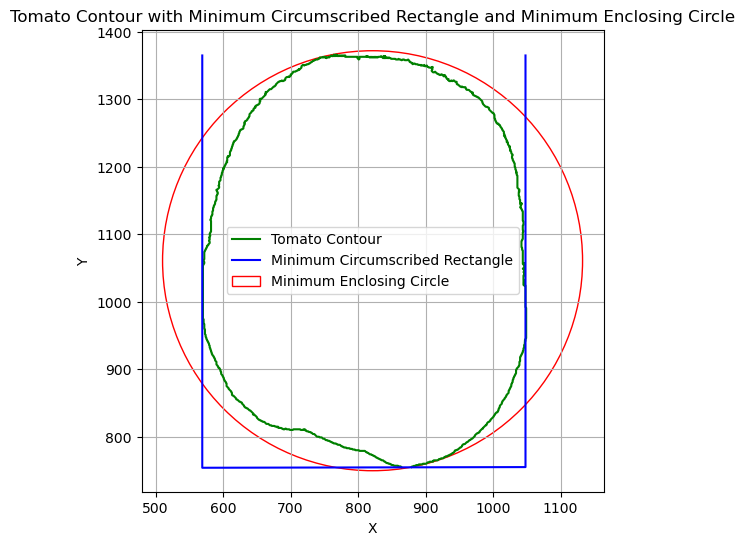

Ratio of Longitudinal Diameter to Transverse Diameter (SC): 0.7839607768628163
Circularity Index of Side Profile (EC): 0.7750545406075685


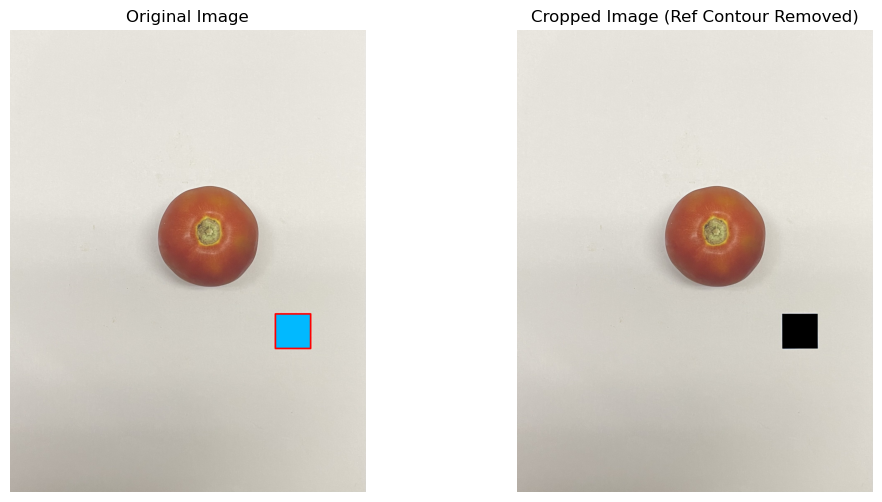

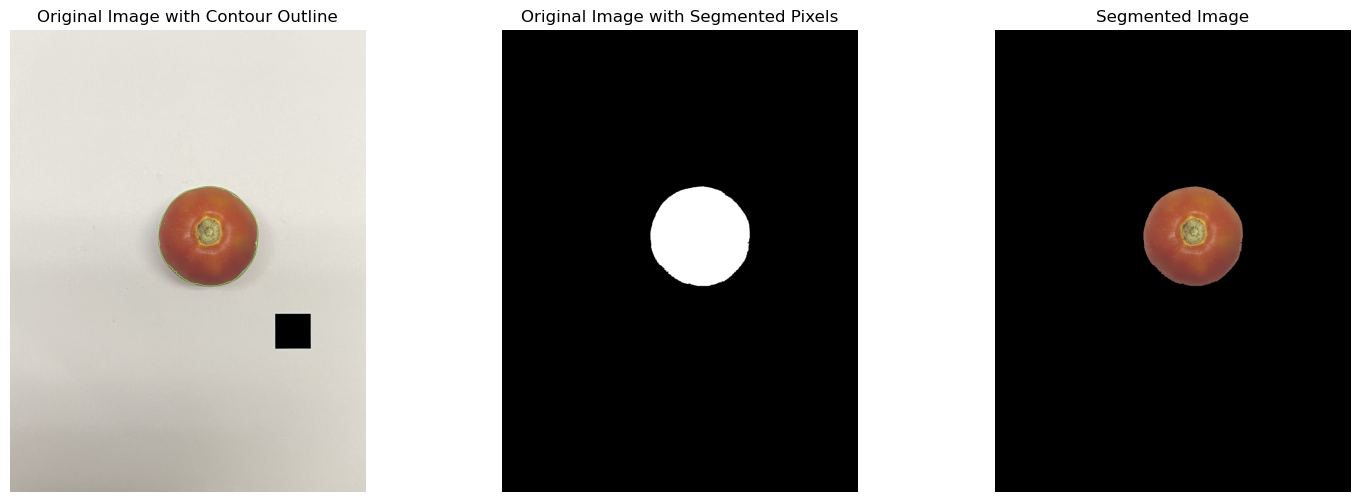

Circularity Indicator E2: 0.9654154265890194
Circularity Indicator E3: 0.8749443786982247


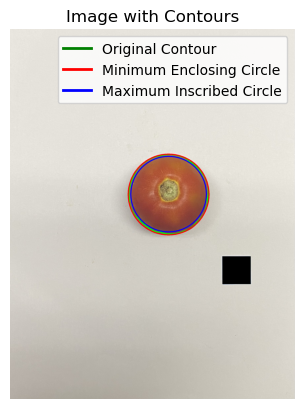

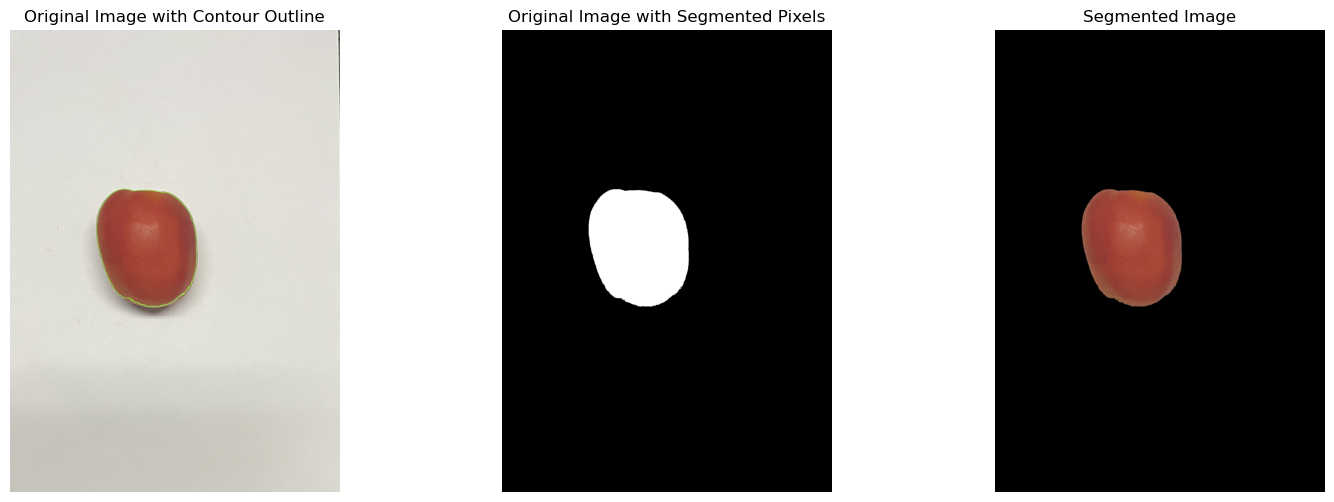

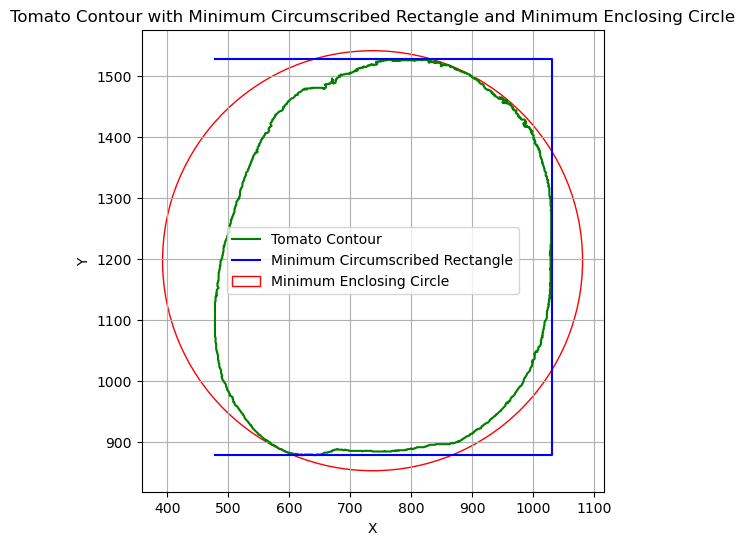

Ratio of Longitudinal Diameter to Transverse Diameter (SC): 0.8505392912172574
Circularity Index of Side Profile (EC): 0.7856182011065186
5.753363228699551
[['E2', 0.9654154265890194], ['E3', 0.8749443786982247]]
[['SC', 0.7839607768628163], ['EC', 0.7750545406075685]]
[['SC', 0.8505392912172574], ['EC', 0.7856182011065186]]


In [3]:
def getImgs(input_folder):
    # List all files in the directory
    files = os.listdir(input_folder)

    # Filter only .jpg files
    files = [file for file in files if file.endswith('.jpg')]

    # Construct relative paths for each .jpg file and add tags based on file names
    img_paths_tags = []
    for file in files:
        file_path = os.path.join(input_folder, file)
        tag = None
        if 'top' in file.lower():
            tag = 'top'
        elif 'side' in file.lower():
            tag = 'side'
        img_paths_tags.append([file_path, tag])

    return img_paths_tags

pType = "tomato"
input_folder = "Custom_Images/tomato"
img_info = []
size = {
    'diameter': 0.0,
    'length' : 0.0
}
shape = {
    'top': [],
    'side_1': [],
    'side_2': []
}

if pType == "tomato":
    img_info = getImgs(input_folder)
    ref_local = "top"
    sView = 'side_1'
    # print (img_info)


    for i in img_info:
        path = i[0]
        view = i[1]

        img = cv2.imread(path)
        
        if (view == ref_local):
            img, pixel_conversion = FindReference(img)
            main_contour = SegmentImage(img)
            size['diameter'] = CalcSize_Tomato(img, main_contour, pixel_conversion)
            shape['top'] = FindShape_Top(img, main_contour)
        else:
            main_contour = SegmentImage(img)
            shape[sView] = FindShpae_Side_Tomato(main_contour)
            sView = 'side_2'


    print ('----------------------------\n')
    print ('Diameter: ',size['diameter'])
    print ('\n----------------------------\n')
    print ('\n----------------------------\n')
    print ('Top Shape: ', shape['top'])
    print ('Side Shape [1]: ',shape['side_1'])
    print ('Side Shape [2]: ',shape['side_2'])
    print ('\n----------------------------\n')


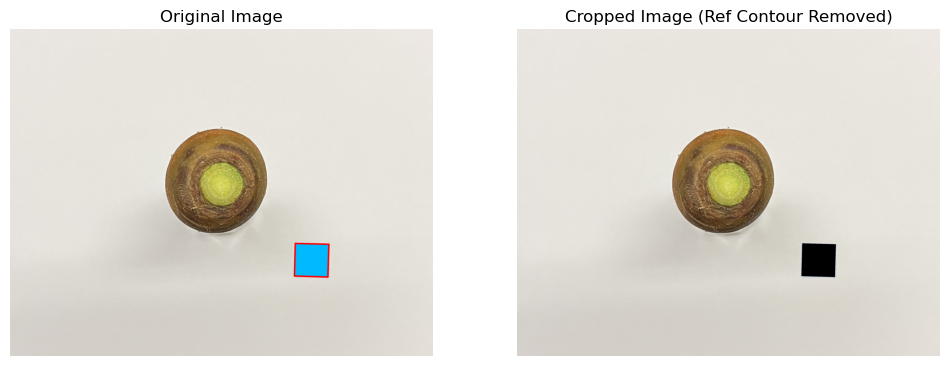

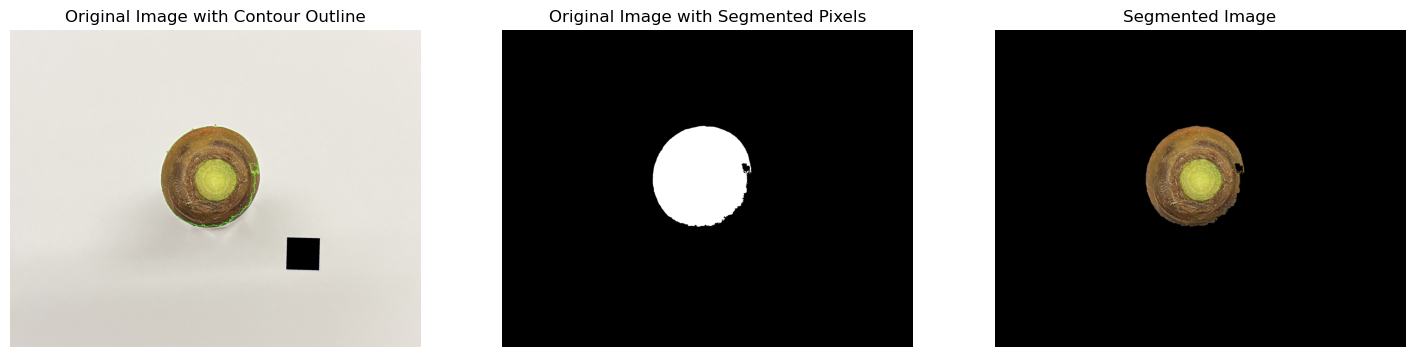

Pixel conversion:  0.008617808141029165
Circularity Indicator E2: 0.8975754634428336
Circularity Indicator E3: 0.6274307479224377


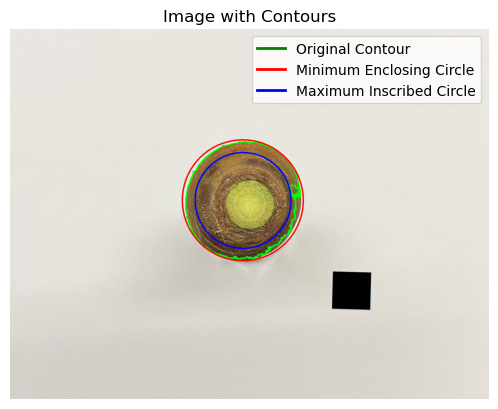

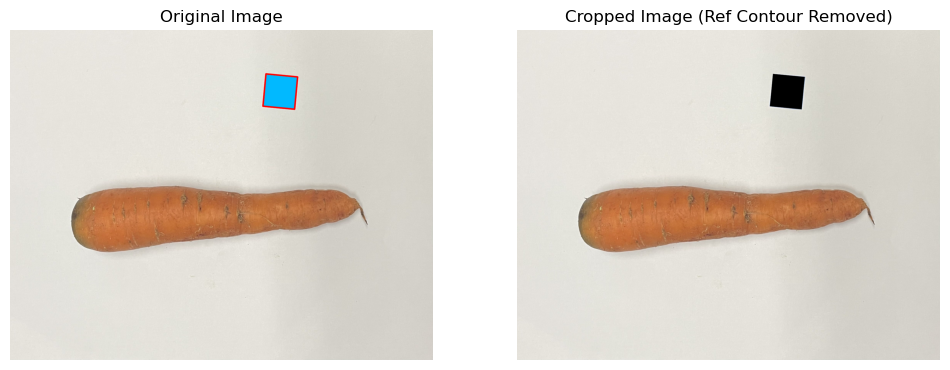

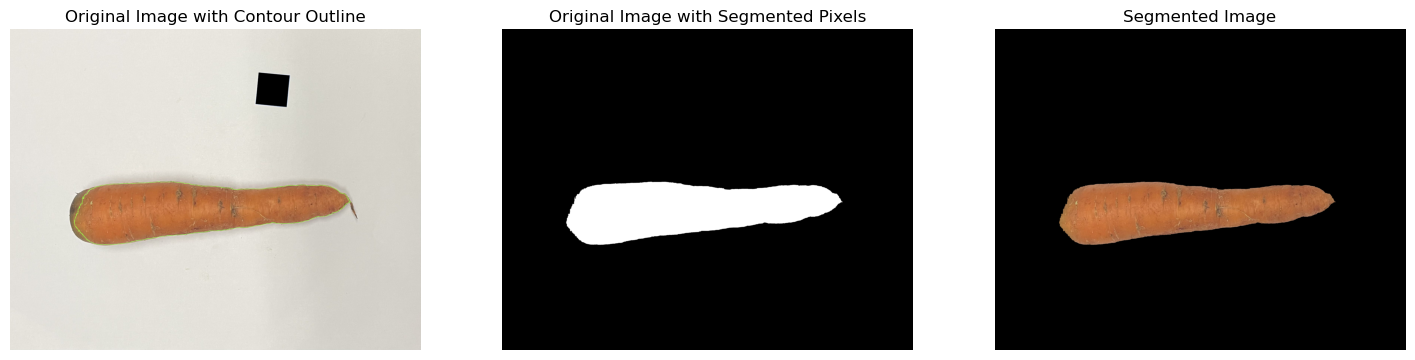

Pixel conversion:  0.008889591304100787
432.67077553262135


IoU Score: 0.5969596455079381
Similarity Score: 0.5354168094583437


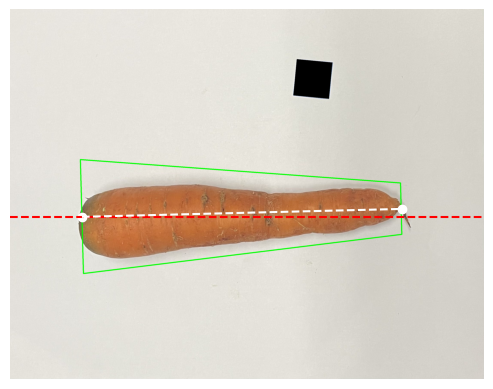

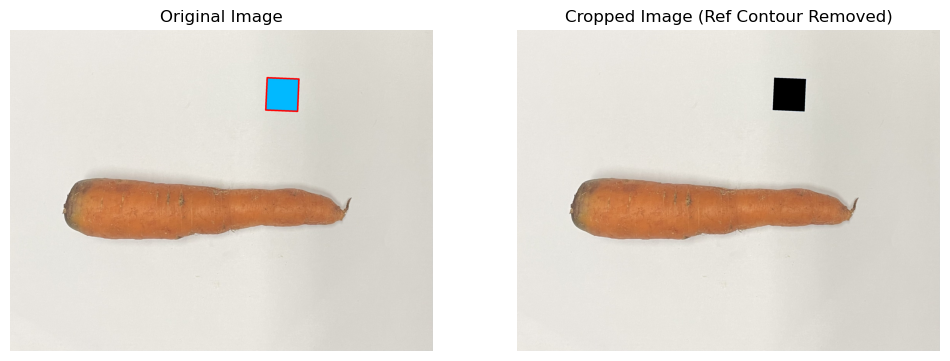

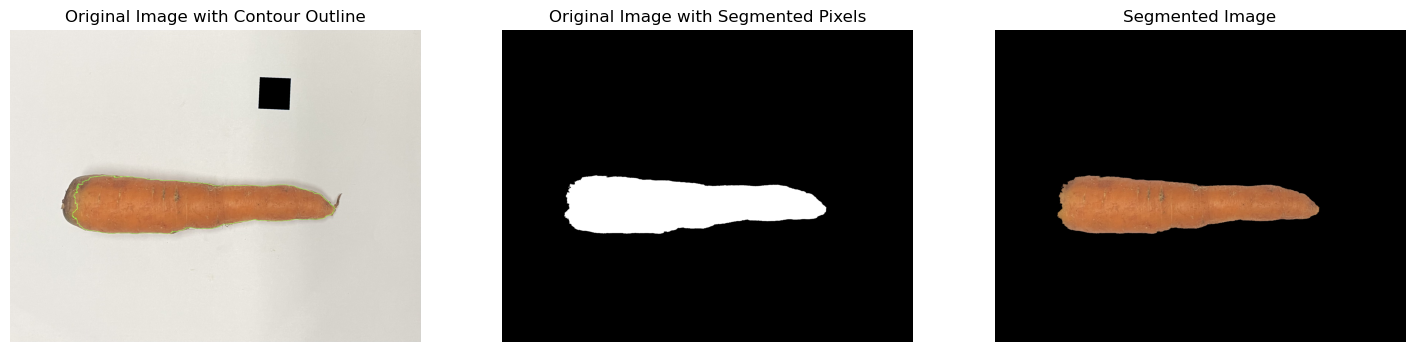

Pixel conversion:  0.008919687452491776
413.533553656774


IoU Score: 0.5895508786337392
Similarity Score: 0.5556741387584138


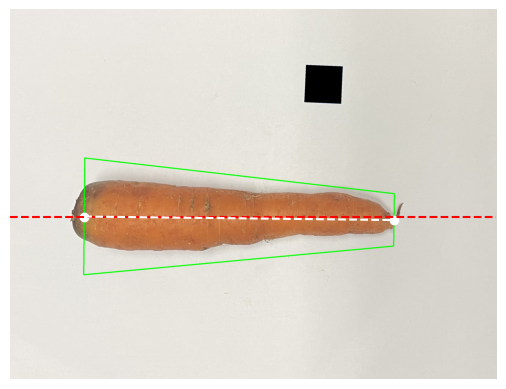

6.290999942951291
[['E2', 0.8975754634428336], ['E3', 0.6274307479224377]]
[['IoU', 0.5969596455079381], ['Sim_score', 0.5354168094583437]]
[['IoU', 0.5895508786337392], ['Sim_score', 0.5556741387584138]]


In [4]:
def getImgs(input_folder):
    # List all files in the directory
    files = os.listdir(input_folder)

    # Filter only .jpg files
    files = [file for file in files if file.endswith('.jpg')]

    # Construct relative paths for each .jpg file and add tags based on file names
    img_paths_tags = []
    for file in files:
        file_path = os.path.join(input_folder, file)
        tag = None
        if 'top' in file.lower():
            tag = 'top'
        elif 'side' in file.lower():
            tag = 'side'
        img_paths_tags.append([file_path, tag])

    return img_paths_tags

pType = "carrot"
input_folder = "Custom_Images/carrot"
img_info = []
size = {
    'diameter': 0.0,
    'length' : 0.0
}
shape = {
    'top': [],
    'side_1': [],
    'side_2': []
}

if pType == "carrot":
    img_info = getImgs(input_folder)
    ref_local = "top"
    sView = 'side_1'
    # print (img_info)
    rep = False


    for i in img_info:
        path = i[0]
        view = i[1]

        img = cv2.imread(path)
        
        
        img, pixel_conversion = FindReference(img)
        main_contour = SegmentImage(img)
        print ("Pixel conversion: ", pixel_conversion)

        if view == 'top':
            size['diameter'] = CalcSize_Carrot(main_contour, pixel_conversion, view)
        elif rep==False:
            size['length'] = CalcSize_Carrot(main_contour, pixel_conversion, view)

        if view == 'top':
            shape['top'] = FindShape_Top(img, main_contour)
        else:
            width = size['diameter'] / pixel_conversion
            shape[sView] = FindShape_Side_Carrot(img ,main_contour, width)
            sView = 'side_2'

    print ('----------------------------\n')
    print ('Diameter: ',size['diameter'])
    print ('Length: ',size['length'])
    print ('\n----------------------------\n')
    print ('\n----------------------------\n')
    print ('Top Shape: ', shape['top'])
    print ('Side Shape [1]: ',shape['side_1'])
    print ('Side Shape [2]: ',shape['side_2'])
    print ('\n----------------------------\n')
